## Bike Sharing Project using Dask

Carolin Kroeger

In [1]:
!pip -q install "dask[complete]"
!pip -q install "dask-ml[complete]"

In [2]:
import numpy as np
import pandas as pd

from math import sqrt
from scipy import stats

import dask.dataframe as dd
import dask.array as da

import dask_ml
from dask_ml.preprocessing import DummyEncoder
from dask_ml.linear_model import LinearRegression
from dask.distributed import Client
from dask_ml.linear_model import LogisticRegression

import sklearn
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.externals.joblib import parallel_backend
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

lg = LogisticRegression()
lr = LinearRegression()

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

/Applications/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Applications/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [3]:
#!curl -O "https://raw.githubusercontent.com/CarolinKroeger/hour.csv"

In [4]:
%time hour_df = dd.read_csv("/Users/carolinkroeger/Desktop/Bike_Sharing_Dataset/hour.csv")

CPU times: user 18.5 ms, sys: 4.46 ms, total: 23 ms
Wall time: 24.1 ms


In [5]:
hour_df.head(2)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40


#### Pre-processing

In [6]:
# Rename columns
hour_df = hour_df.rename(
    columns={
        "dteday": "date",
        "mnth": "month",
        "yr": "year",
        "hr": "hour",
        "weathersit": "weather",
        "cnt": "count",
        "hum": "humidity",
        "temp": "temperature"
    }
)

In [7]:
hour_df.isnull().sum().compute()

instant        0
date           0
season         0
year           0
month          0
hour           0
holiday        0
weekday        0
workingday     0
weather        0
temperature    0
atemp          0
humidity       0
windspeed      0
casual         0
registered     0
count          0
dtype: int64

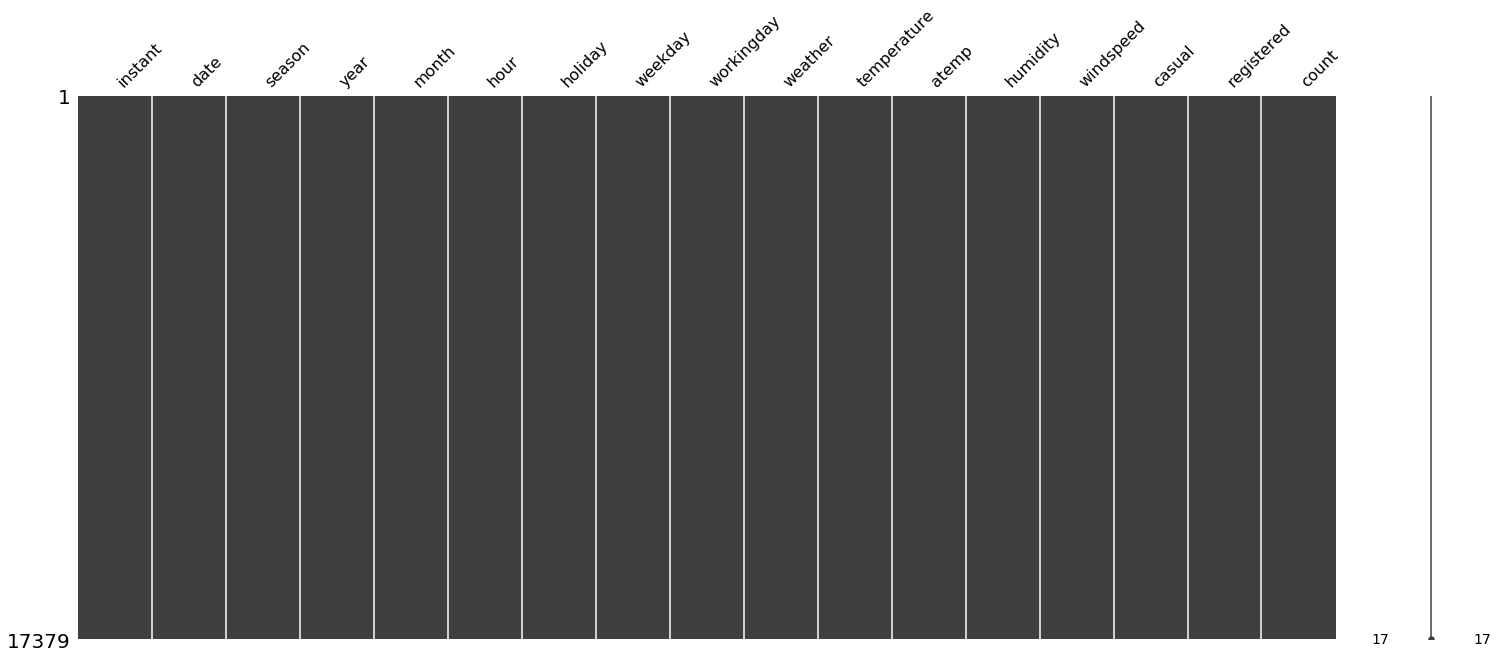

In [8]:
msno.matrix(hour_df.compute())

In [9]:
hour_df.dtypes

instant          int64
date            object
season           int64
year             int64
month            int64
hour             int64
holiday          int64
weekday          int64
workingday       int64
weather          int64
temperature    float64
atemp          float64
humidity       float64
windspeed      float64
casual           int64
registered       int64
count            int64
dtype: object

In [10]:
# Predict count so casual and registered can be left out
hour_df = hour_df.drop(["casual", "registered"], axis=1)

In [11]:
# Datatype object to date
hour_df["date"] = dd.to_datetime(hour_df.date)

In [12]:
# Convert final data in right format
hour_df["season"] = hour_df["season"].astype("category")
hour_df["year"] = hour_df["year"].astype("category")
hour_df["month"] = hour_df["month"].astype("category")
hour_df["hour"] = hour_df["hour"].astype("category")
hour_df["weekday"] = hour_df["weekday"].astype("category")
hour_df["workingday"] = hour_df["workingday"].astype("category")
hour_df["holiday"] = hour_df["holiday"].astype("category")
hour_df["weather"] = hour_df["weather"].astype("category")

Check for correlation between features to see if any of them are potentially redundant:


In [13]:
correlation=hour_df.compute()[['temperature','atemp','humidity','windspeed','count']].corr()
#correlation.style.background_gradient(cmap='GnBu').set_precision(2)
#sns.heatmap(correlation,cmap='coolwarm',square=True,center=0,annot=True)

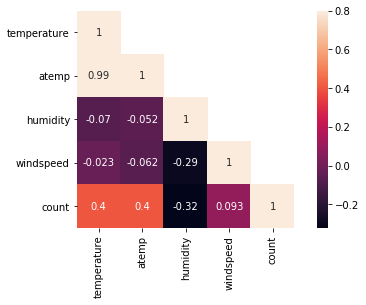

In [14]:
mask = np.array(correlation)
mask[np.tril_indices_from(mask)] = False
fig, ax = plt.subplots()
fig.set_size_inches(8, 4)
sns.heatmap(correlation, mask=mask, vmax=0.8, square=True, annot=True)

In [15]:
# Remove (a)temp because of the almost 1 to 1 correlation with atemp.
hour_df = hour_df.drop(["atemp"], axis=1)
hour_df.head(2)

,instant,date,season,year,month,hour,holiday,weekday,workingday,weather,temperature,humidity,windspeed,count
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.81,0.0,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.80,0.0,40


Now it will be interesting to take a look at the distribution of the rentals over the different months.

[Text(0, 0.5, 'Average Count'),
 Text(0.5, 0, 'Month'),
 Text(0.5, 1.0, 'Average Count By Month')]

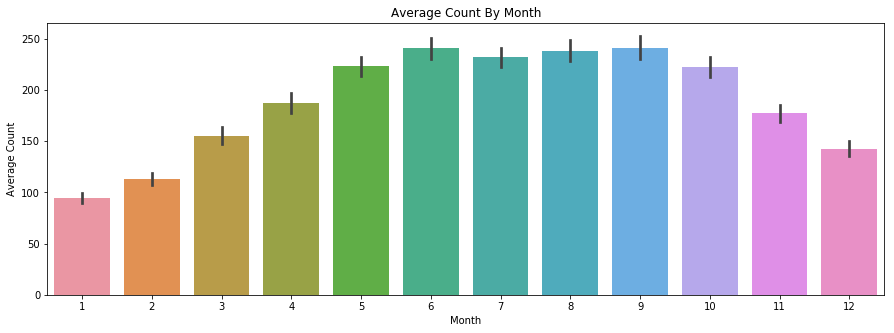

In [16]:
# Plot Monthly Distribution
fig, ax1 = plt.subplots()
fig.set_size_inches(15, 5)
sns.barplot(data=hour_df.compute(), x="month", y="count", ax=ax1)
ax1.set(xlabel="Month", ylabel="Average Count", title="Average Count By Month")

Looking at the distribution of the rentals on a daily basis there are clearly periods of higher demand during a day, ie the moments people have to get home from/ go to work/school, and the other moments of the day.
Of course there is a big seasonal effect as well as an effect of wheteher it is a working day or not.

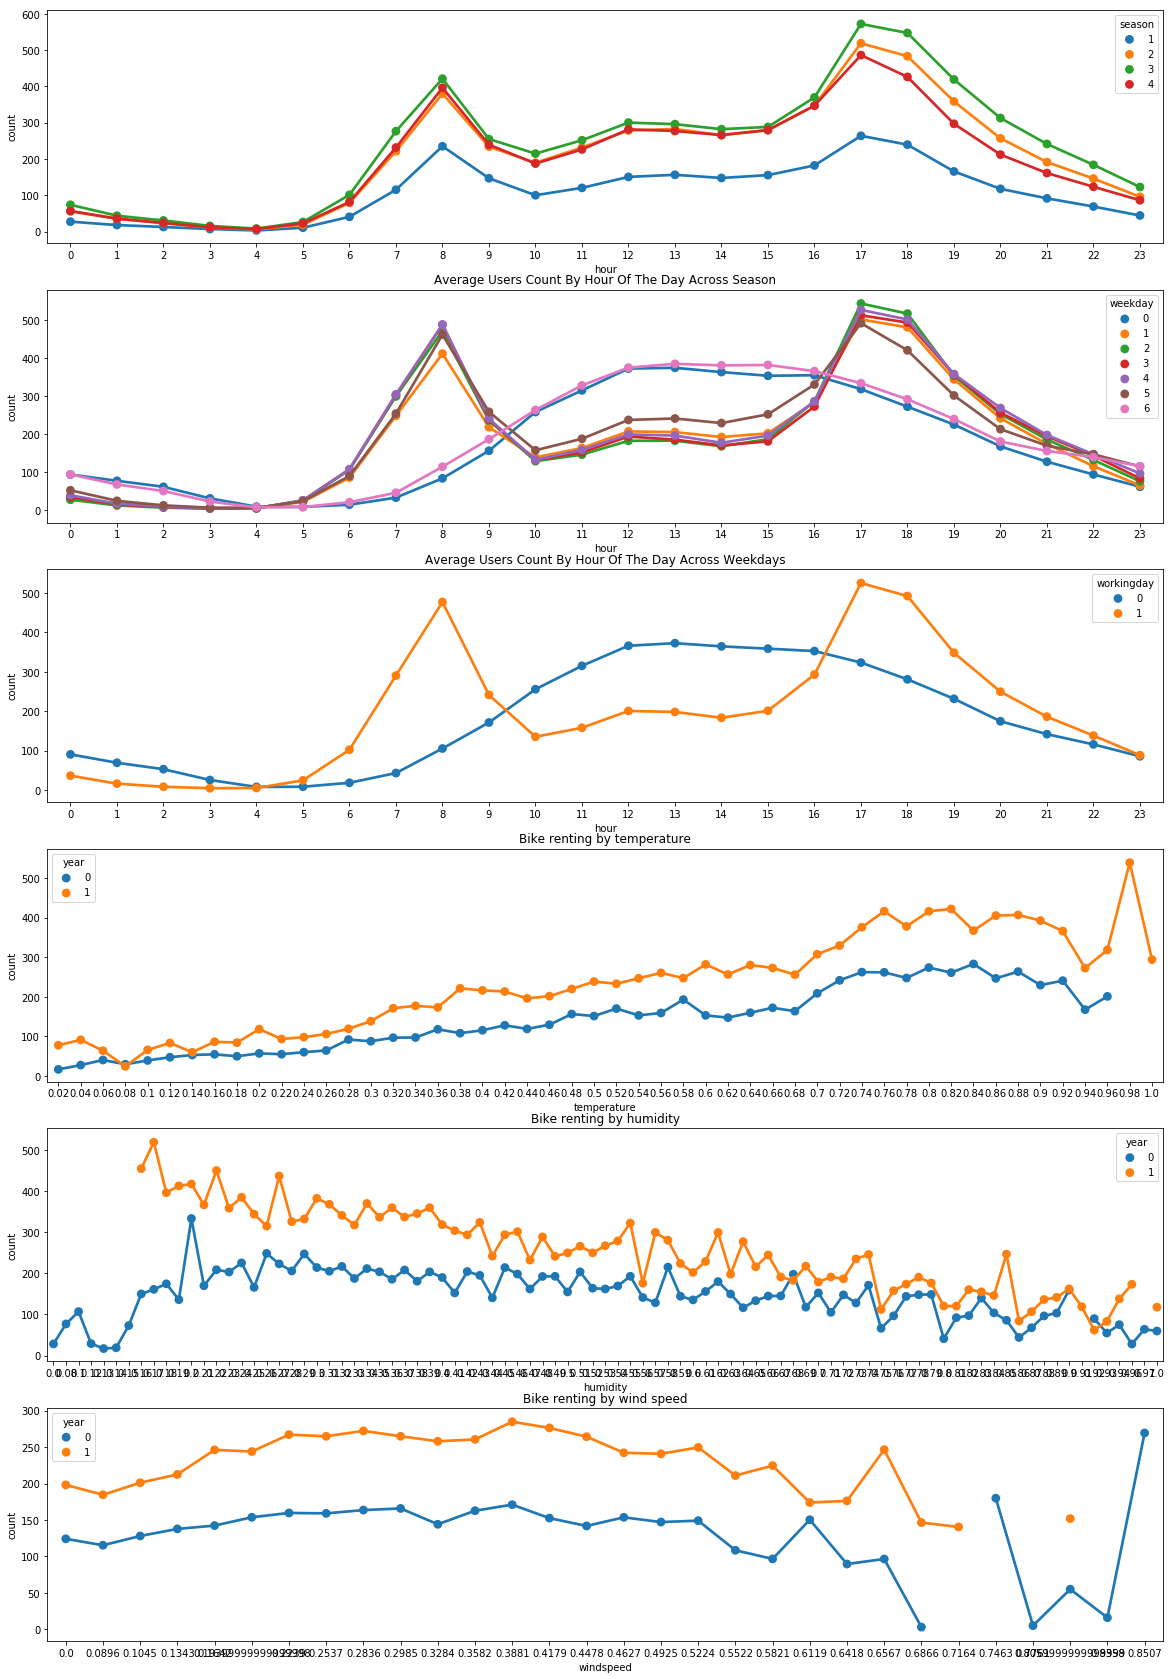

In [17]:
# Plot hourly distributions regarding season, day of week, workday
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=6)
fig.set_size_inches(20, 30)

hourAggregated = pd.DataFrame(
    hour_df.compute().groupby(["hour", "season"], sort=True)["count"].mean()
).reset_index()
sns.pointplot(
    x=hourAggregated["hour"],
    y=hourAggregated["count"],
    hue=hourAggregated["season"],
    data=hourAggregated,
    join=True,
    ax=ax1,
)
ax2.set(
    xlabel="Hour Of The Day",
    ylabel="Users Count",
    title="Average Users Count By Hour Of The Day Across Season",
    label="big",
)

hourAggregated = pd.DataFrame(
    hour_df.compute().groupby(["hour", "weekday"], sort=True)["count"].mean()
).reset_index()
sns.pointplot(
    x=hourAggregated["hour"],
    y=hourAggregated["count"],
    hue=hourAggregated["weekday"],
    data=hourAggregated,
    join=True,
    ax=ax2,
)
ax3.set(
    xlabel="Hour Of The Day",
    ylabel="Users Count",
    title="Average Users Count By Hour Of The Day Across Weekdays",
    label="big",
)

hourAggregated = pd.DataFrame(
    hour_df.compute().groupby(["hour", "workingday"], sort=True)["count"].mean()
).reset_index()
sns.pointplot(
    x=hourAggregated["hour"],
    y=hourAggregated["count"],
    hue=hourAggregated["workingday"],
    data=hourAggregated,
    join=True,
    ax=ax3,
)

ax4.set(
    xlabel="Temperature",
    ylabel="Users Count",
    title="Bike renting by temperature",
    label="big",
)

hourAggregated = pd.DataFrame(
    hour_df.compute().groupby(["temperature", "year"], sort=True)["count"].mean()
).reset_index()
sns.pointplot(
    x=hourAggregated["temperature"],
    y=hourAggregated["count"],
    hue=hourAggregated["year"],
    data=hourAggregated,
    join=True,
    ax=ax4,
)

ax5.set(
    xlabel="Humidity",
    ylabel="Users Count",
    title="Bike renting by humidity",
    label="big",
)

hourAggregated = pd.DataFrame(
    hour_df.compute().groupby(["humidity", "year"], sort=True)["count"].mean()
).reset_index()
sns.pointplot(
    x=hourAggregated["humidity"],
    y=hourAggregated["count"],
    hue=hourAggregated["year"],
    data=hourAggregated,
    join=True,
    ax=ax5,
)

ax6.set(
    xlabel="Wind Speed",
    ylabel="Users Count",
    title="Bike renting by wind speed",
    label="big",
)

hourAggregated = pd.DataFrame(
    hour_df.compute().groupby(["windspeed", "year"], sort=True)["count"].mean()
).reset_index()
sns.pointplot(
    x=hourAggregated["windspeed"],
    y=hourAggregated["count"],
    hue=hourAggregated["year"],
    data=hourAggregated,
    join=True,
    ax=ax6,
)

Check for Outliers
- Important: Seperate test and train data for outlier removal (at the date)

In [18]:
hour_df["date"].dtype

index = (hour_df.date < "2012-10-01")

hour_df_train = hour_df[index]
hour_df_test = hour_df[~index]

In [19]:
print(len(hour_df_train),
len(hour_df_test))

15211 2168


In [20]:
len(hour_df_train)+len(hour_df_test)==len(hour_df)

True

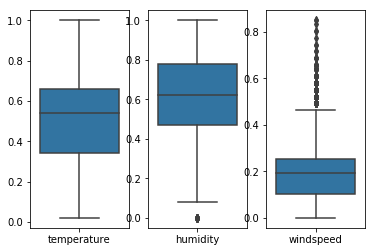

In [21]:
# Let's first check outliers using Box-plots
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)

sns.boxplot(data=hour_df_train[["temperature"]].compute(), ax=ax1)
sns.boxplot(data=hour_df_train[["humidity"]].compute(), ax=ax2)
sns.boxplot(data=hour_df_train[["windspeed"]].compute(), ax=ax3)

/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


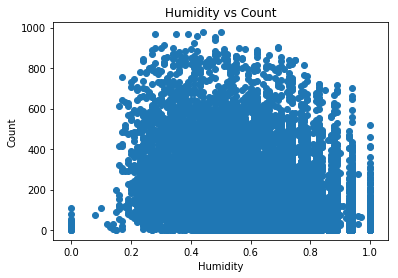

In [22]:
# Humidity & Count
fig, ax = plt.subplots()
ax.scatter(
    hour_df_train[["humidity"]].compute(), hour_df_train[["count"]].compute()
)
plt.title("Humidity vs Count")
ax.set_xlabel("Humidity")
ax.set_ylabel("Count")
fig.show()

/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


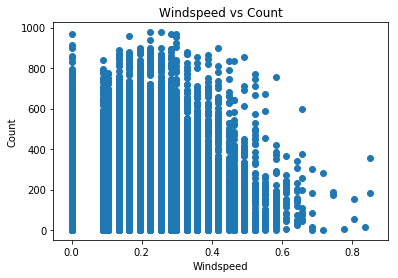

In [23]:
# Windspeed & Count
fig, ax = plt.subplots()
ax.scatter(hour_df_train[["windspeed"]].compute(), hour_df_train[["count"]].compute())
plt.title("Windspeed vs Count")
ax.set_xlabel("Windspeed")
ax.set_ylabel("Count")
fig.show()

/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


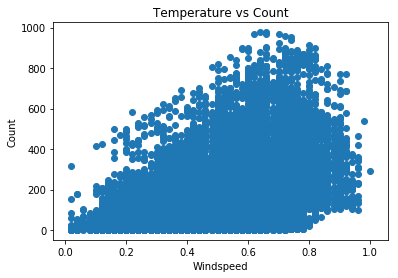

In [24]:
# Temperature & Count
fig, ax = plt.subplots()
ax.scatter(hour_df_train[["temperature"]].compute(), hour_df_train[["count"]].compute())
plt.title("Temperature vs Count")
ax.set_xlabel("Windspeed")
ax.set_ylabel("Count")
fig.show()

There where some outliers located in the numerical variables. We therefore tested our predictions with removing outliers outside three standard deviations from the mean of each variable. This process yielded the highest results when removing outliers only for "humidity"

In [25]:
# Eliminate the outliers detected using the boxplot.
#hour_no = hour_df[
    #np.abs(hour_df["windspeed"] - hour_df["windspeed"].mean()) <= (3 * hour_df["windspeed"].std())
#]

#hour_no = hour_no[
    #np.abs(hour_no["temp"] - hour_no["temp"].mean()) <= (3 * hour_no["temp"].std())
#]

hour_df_train = hour_df_train[
    np.abs(hour_df_train["humidity"] - hour_df_train["humidity"].mean()) <= (3 * hour_df_train["humidity"].std())
]

#### Machine Learning - Predictive Analysis

Encode the variables 

In [26]:
from dask_ml.preprocessing import DummyEncoder
dummy_encoder = DummyEncoder()

In [27]:
hour_df_train_enc = dummy_encoder.fit_transform(hour_df_train.categorize())
hour_df_test_enc = dummy_encoder.fit_transform(hour_df_test.categorize())

hour_df_test_enc.head()

,instant,date,temperature,humidity,windspeed,count,season_1,season_2,season_3,season_4,...,weekday_3,weekday_4,weekday_5,weekday_6,workingday_0,workingday_1,weather_1,weather_2,weather_3,weather_4
15211,15212,2012-10-01,0.46,0.72,0.1045,45,0,0,0,1,...,0,0,0,0,0,1,1,0,0,0
15212,15213,2012-10-01,0.44,0.77,0.0896,18,0,0,0,1,...,0,0,0,0,0,1,1,0,0,0
15213,15214,2012-10-01,0.46,0.72,0.0000,12,0,0,0,1,...,0,0,0,0,0,1,1,0,0,0
15214,15215,2012-10-01,0.44,0.77,0.0000,7,0,0,0,1,...,0,0,0,0,0,1,1,0,0,0
15215,15216,2012-10-01,0.42,0.82,0.1045,10,0,0,0,1,...,0,0,0,0,0,1,1,0,0,0


In [28]:
print(len(hour_df_train_enc),
len(hour_df_test_enc))

15189 2168


In [29]:
y_train = hour_df_train_enc[["count"]]
X_train = hour_df_train_enc.drop(["count", "date", "instant"], 1)

y_test = hour_df_test_enc[["count"]]
X_test = hour_df_test_enc.drop(["count", "date", "instant"], 1)

In [30]:
print(len(y_train),
len(X_train),
len(y_test),
len(X_test))

15189 15189 2168 2168


Linear Regression Model

In [31]:
lr_model = lr.fit(X_train.values, y_train.values)

In [32]:
lr_model_pred = lr_model.predict(X_test.values)

In [33]:
# Calculate the R2 score
r2_score(y_test.values.compute(), lr_model_pred.compute())

0.6353345097622047

In [34]:
# Calculate the Mean Absolute Error (MAE) score
mean_absolute_error(y_test.values.compute(), lr_model_pred.compute())

89.07060392327162

In [35]:
# Calculate the Mean Squared Error (MSE) score
mean_squared_error(y_test.values.compute(), lr_model_pred.compute())

14818.875580558324

Create a Client

In [36]:
dask_client = Client()
dask_client

/Applications/anaconda3/lib/python3.7/site-packages/distributed/bokeh/core.py:57: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


Client Scheduler: tcp://127.0.0.1:51625 Dashboard: http://127.0.0.1:51626/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


Random Forest Model

In [37]:
rf = RandomForestRegressor()

In [38]:
parameters = {'max_depth': (5, 15, 10, 25),
              'n_estimators': (50, 150, 250, 300),
             }
grid_search = GridSearchCV(estimator=rf, param_grid=parameters)

In [39]:
with parallel_backend('dask'):
    grid_search.fit(X_train.compute(), y_train.compute())

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:740: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [40]:
grid_search.best_params_

{'max_depth': 25, 'n_estimators': 150}

In [41]:
# Adjusting the parameters to the most optimal Random Forest model
rf = RandomForestRegressor(max_depth = 25, n_estimators = 150)

In [42]:
rf.fit(X_train.values, y_train.values)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [43]:
rf_model_pred = rf.predict(X_test.values)
rf_model_pred

array([ 47.53381806,  17.76668709,   9.5514181 , ..., 111.92250534,
        95.12665008,  52.25543009])

In [44]:
#mean_absolute_error(y_test.values, rf_model_pred)